# Project Introduction - Customer Segmentation (Part 2)
The goal of this project is to analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population with the aim of understanding which segment of the population the company should aim for in its next mail campaign. 

The project is divided into __three main parts__:
1. The first part will be decicated to the data preparation: This data is high-dimensional and has a high degree of missing values, therefore it is important to understand and clean the data.
2. In this section the customers will be segmented using a __unsupervised learning approach__ and using the customer's data against the general population's data. Not only is the goal to understand which groups of customers are more interesting for the campaign but also to select the most important features.
3. Using the information gained a __supervised learning algorithm__ will be used for a classification task to predict which recipients are most likely to become a customer for the mail-order company.

__Note__: This notebook handles part 2. The first part of the data cleaning process can be found in this notebook [here](https://github.com/bruno-f7s/portfolio/blob/main/arvarto-customer-segmentation/01-data-cleaning.ipynb).

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from joblib import dump

# magic word for producing visualizations in notebook
%matplotlib inline

# configurations
pd.options.display.max_columns = 500
pd.options.display.max_rows = 500
pd.set_option('display.max_colwidth', None)

# PART 2: Customer Segmentation (Unsupervised Learning)
In this section we will try to understand which parts of the customers data are overrepresented or underrepresented in the population dataset with the goal of identifying the types of customers the company should target. This will be done by clustering both datasets and see how the distribution of the clusters looks like. Since we have more than 350 columns, it is a good idea to reduce the complexity of the problem to avoid redundancy and overfitting issues.

The approach looks like this:
1.	Reduce the dimensionality using PCA to a certain n number of components that explain at least __85%__ of the variance.
2.	Find the top 20 features which have the most impact on the total components, so we can use them to understand customer segments.
3.	Find a k number of clusters for the n components of the population data using the elbow method and use the ideal k to cluster the customer dataset.
4.	Compare the distribution of the clusters for the population with the customers’ dataset and see which ones are overrepresented or underrepresented.
5.	Make a centroid analysis of the clusters using for top 20 features to understand the types of customers the company should target or avoid. 


In [2]:
# Load the cleaned data for the customer segmentation part
population_df = pd.read_csv('data\\Cleaned_Udacity_AZDIAS_052018.csv', sep=';')
customers_df = pd.read_csv('data\\Cleaned_Udacity_CUSTOMERS_052018.csv', sep=';')

# Load the attributes df
attributes_df = pd.read_excel('data-dictionary\\DIAS Attributes - Values 2017.xlsx', usecols = [1,2,3,4], skiprows=1)
attributes_df = attributes_df.fillna(method="ffill")
attributes_nms = list(attributes_df["Attribute"].unique())

In [3]:
population_df.shape

(613991, 344)

## 1.1 Dimensionality Reduction
- We will use the population dataset to understand which number of components should be chosen for the threshold of 85% variance explained. Then we will also see which number clusters are a good fit for this data. 
- To test for robustness, we will also conduct the same analysis with 3 other subsets of the data and see if the results are similar.

### Population dataset

In [4]:
def plot_pca(df, df_name, threshhold):
    """
    This function plots the cumulative explained variance using PCA for a particular threshold of explained variance. 
    It takes in as arguments a dataset, the name of the dataset and a threshhold to find the number of components for that explained variance.

    """
    # Step 1: Scale the data
    sc = StandardScaler()
    scaled_df = sc.fit_transform(df)
    
    # Step 2: Fit a standard PCA to find the n components
    pca = PCA(random_state=101)
    pca_result = pca.fit_transform(scaled_df)

    explained_variance = pca.explained_variance_ratio_
    cum_explained_variance = np.cumsum(explained_variance)
    n_components_for_threshhold = np.where(cum_explained_variance >= threshhold)[0][0]
    
    # Step 3 - Plot the Cumulative Explained Variances
    plt.figure(figsize=(16,6))

    plt.subplot(1, 2, 2)
    plt.plot(range(len(explained_variance)), cum_explained_variance)
    plt.ylabel('Cumulative explained variance ratio')
    plt.xlabel('Number of components')
    plt.title(f'Cumulative Explained Variance Plot for the {df_name}')
    plt.axhline(y=threshhold, color='grey', linestyle='--', label=f'Threshold at {threshhold}') 

    plt.annotate(text = f"{n_components_for_threshhold} components explain\n{round(threshhold*100)}% of the variance.",
                 xy = (n_components_for_threshhold, threshhold),
                 xytext = (n_components_for_threshhold, threshhold-0.1),
                 arrowprops=dict(arrowstyle='->'))

    plt.legend(loc='lower right')

    plt.tight_layout()
    plt.show(); 

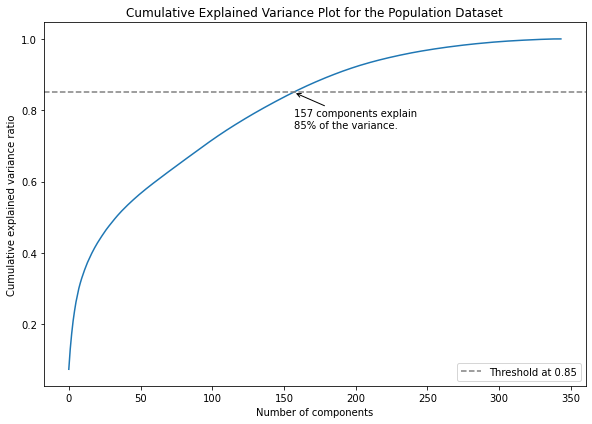

In [5]:
# Plot the PCA for the population dataset for a threshold of 85% of variance explained
plot_pca(population_df, "Population Dataset", 0.85)

__Observation__: We can see that for the whole population dataset __157 components__ would explain 85% of the variance. To be surer that this number is robust and not just due to correlated features, we can plot the same curve for different subsets of the dataset and see if the results keep consistent.

We can create 3 further random subsets plot them together with the population dataset.

In [6]:
# create subsets of the population dataset
dataset_names = ["Population Dataset", "Subset 1 of the Population Dataset", "Subset 2 of the Population Dataset", "Subset 3 of the Population Dataset"]

subset1_population_df = population_df.sample(n = round(len(population_df) * 0.25), random_state=1)
subset2_population_df = population_df.sample(n = round(len(population_df) * 0.4), random_state=51)
subset3_population_df = population_df.sample(n = round(len(population_df) * 0.3), random_state=101)

datasets = [population_df, subset1_population_df, subset2_population_df, subset3_population_df]

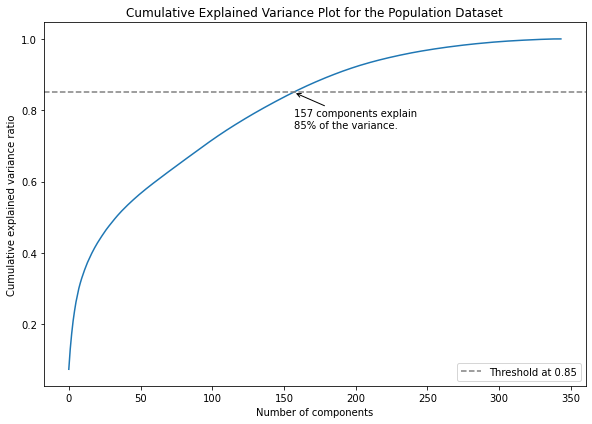

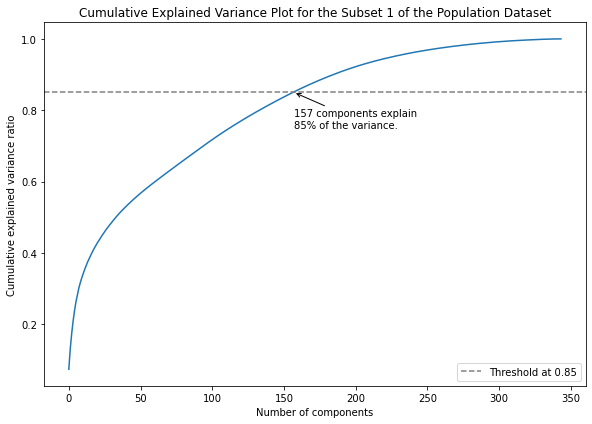

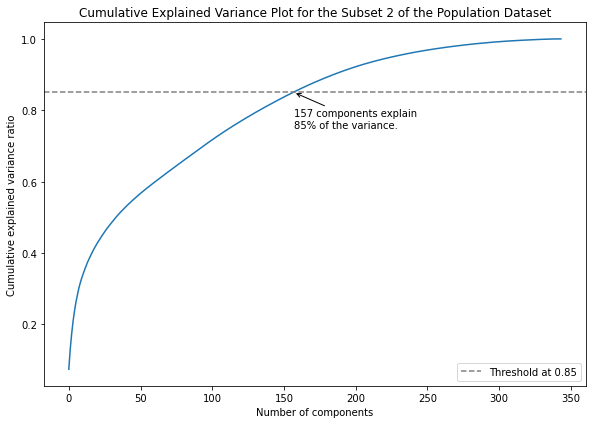

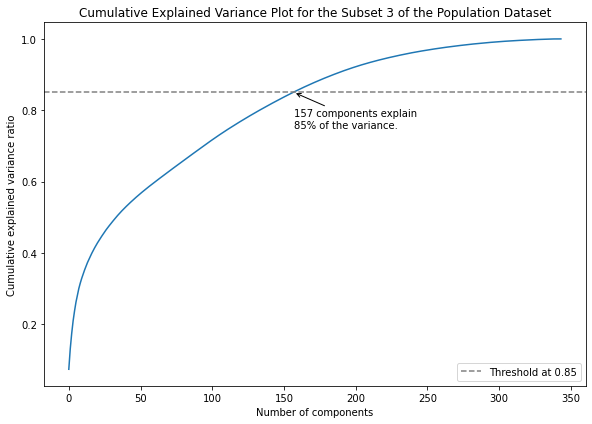

In [7]:
# Plot the PCA of the 4 datasets
for data, name in zip(datasets, dataset_names):
    plot_pca(data, name, 0.85)

__Analysis__: Based on the graphics above we can determine that the initial value of __157 components__ is indeed robust for explaining ca. 85% of the variance of the data. This means that we can reduce the dimensionality of the dataset by half and still maintain the general explainability.

__Observation__: The next step now would be to understand which features are being more important to explain variance of the data. One way to do this would be to look at the first principal component and then the second, which is something that we see a lot in literature. However, these components in this dataset are weak in terms of explaining the variance so if we just focus on those, we will potentially lose some information.

There are some ways we can deal with this issue:
1. We can look the the feature importance for all components at once by squaring the PCA components (loadings) and summing along the columns for all the components.
2. We can find features that show up as the top 10 most influential for each principal component of the list of principal components which have a higher individual variance explained. We can for example take 20 features at the end that we will use to explain the customer segment. This can be done for example by applying an elbow method of the Scree Plot.
    
We can try both and compare the results.

In [8]:
# Scale the data
sc = StandardScaler()
scaled_population_df = sc.fit_transform(population_df)

# Fit the PCA with 157 onto the population dataset
pca = PCA(n_components=157, random_state=101)
pca_population = pca.fit_transform(scaled_population_df)

explained_variance = pca.explained_variance_ratio_
cum_explained_variance = np.cumsum(explained_variance)

__Find top 20 most influential features - Approach 1__

In [9]:
# Compute the Importance (or Influence) of Each Feature:
feature_influence = np.sum(pca.components_**2, axis=0)

# Rank and Select the Top 20 Features
top_20_indices = feature_influence.argsort()[-20:][::-1]

# Get the Names of the Top 20 Features
top_20_features_approach_1 = [list(population_df.columns)[i] for i in top_20_indices]

print(top_20_features_approach_1)

['CAMEO_DEU_2015_5E', 'CAMEO_DEU_2015_5F', 'D19_DIGIT_SERV', 'CAMEO_DEU_2015_7E', 'D19_BANKEN_LOKAL', 'CAMEO_DEU_2015_6D', 'CAMEO_DEU_2015_6F', 'CAMEO_DEU_2015_4D', 'CAMEO_DEU_2015_4E', 'CAMEO_DEU_2015_1B', 'CAMEO_DEU_2015_6A', 'CAMEO_DEU_2015_6C', 'CAMEO_DEU_2015_7D', 'CAMEO_DEU_2015_7C', 'CAMEO_DEU_2015_1C', 'CAMEO_DEU_2015_5B', 'D19_ENERGIE', 'CAMEO_DEU_2015_4B', 'CAMEO_DEU_2015_5C', 'D19_TIERARTIKEL']


__Find top 20 most influential features - Approach 2__

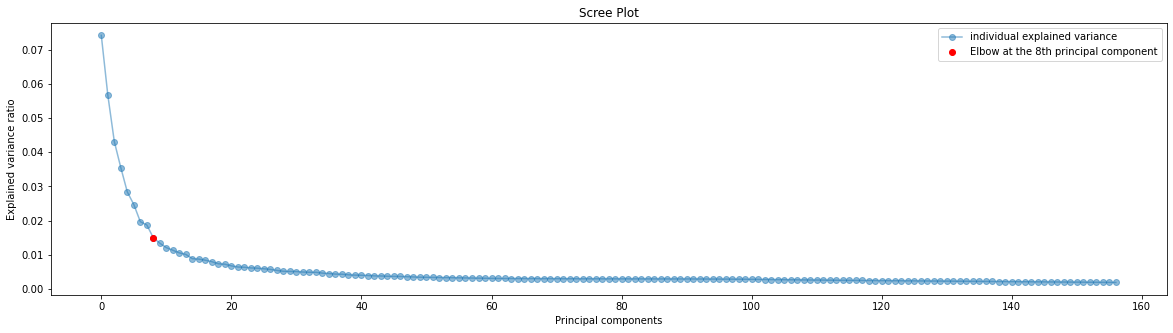

In [10]:
# Scree Plot
plt.figure(figsize=(20,5))
plt.plot(range(len(explained_variance)), explained_variance, alpha=0.5, label='individual explained variance', marker='o')
plt.plot(8, explained_variance[8], 'ro', label="Elbow at the 8th principal component")
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.title('Scree Plot')
plt.legend();

In [11]:
# determine the number of principal components
n_components = 8

# Instantiate an array of zeros for the number of features 
feature_counts = np.zeros(len(population_df.columns))

# For each component of the chosen principal components find the top 10 most influential features and add 1 to the feature counts
for component in pca.components_[:n_components]:
    top_indices = np.abs(component).argsort()[-10:][::-1]
    feature_counts[top_indices] += 1

# Create a DataFrame with the feature counts
feature_counts_df = pd.DataFrame({
    'Feature': population_df.columns,
    'Counts': feature_counts
})

# Filter out columns which are not important for an individual analysis
feature_counts_df = feature_counts_df[~feature_counts_df["Feature"].str.contains("KBA|D19")].sort_values("Counts",ascending=False)

top_20_features = feature_counts_df["Feature"].head(20).to_list()

print(top_20_features)

['PRAEGENDE_JUGENDJAHRE', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_FAM', 'FINANZ_SPARER', 'SEMIO_TRADV', 'ONLINE_AFFINITAET', 'SEMIO_PFLICHT', 'LP_STATUS_FEIN', 'MOBI_REGIO', 'SEMIO_KRIT', 'OST_WEST_KZ', 'SEMIO_KAEM', 'HH_EINKOMMEN_SCORE', 'PLZ8_ANTG1', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_BAUMAX', 'PLZ8_HHZ', 'SEMIO_RAT']


__Analysis:__ We can see that the two approaches lead to different features and deciding which one is the best would be better with a domain expert. Since this is something not available, I decided to go for the second approach because we are only considering the features which individually contribute the most for a higher variability in the explained variance. 

If we would include all the components in this analysis, it is likely that when the explained variance does not change that much, the features which contribute the most for these small changes will repeat themselves and therefore at the end automatically have the highest counts. We are interested in the top features which influence the explained variability the most.

I decided to remove all `D19` columns because they relate to money transactions information and the `KBA` columns because they relate to many metrics about cars. I thought that those wouldn't be so relevant to analyse customer segments. 
Based on this analysis these are the features to be considered for the customer segmentation analysis when we cluster the data:
- `FINANZ_SPARER`: financial typology: money saver.
- `HH_EINKOMMEN_SCORE`: estimated household net income.
- `LP_STATUS_FEIN`: social status fine.
- `MOBI_REGIO`: moving patterns.
- `ONLINE_AFFINITAET`: online affinity.
- `OST_WEST_KZ`: flag indicating the former GDR/FRG
- `PLZ8_ANTG1`: number of 1-2 family houses in the PLZ8.
- `PLZ8_ANTG3`: number of 6-10 family houses in the PLZ8.
- `PLZ8_ANTG4`: number of >10 family houses in the PLZ8.
- `PLZ8_BAUMAX`: most common building-type within the PLZ8.
- `PLZ8_HHZ`: number of households within the PLZ8.
- `PRAEGENDE_JUGENDJAHRE`: dominating movement in the person's youth (avantgarde or mainstream).
- `SEMIO_ERL`: affinity indicating in what way the person is eventful orientated.
- `SEMIO_FAM`: affinity indicating in what way the person is familiar minded.
- `SEMIO_KAEM`: affinity indicating in what way the person is of a fightfull attitude.
- `SEMIO_KRIT`: affinity indicating in what way the person is critical minded.
- `SEMIO_KULT`: affinity indicating in what way the person is cultural minded.
- `SEMIO_PFLICHT`: affinity indicating in what way the person is dutyfull traditional minded.
- `SEMIO_RAT`: affinity indicating in what way the person is of a rational mind.
- `SEMIO_TRADV`: affinity indicating in what way the person is traditional minded.

### Customers dataset
Here we can apply the same dimensionality reduction as before.

In [12]:
# Scale the data using the same scaler from the population dataset
scaled_customers_df = sc.transform(customers_df)

# Fit the PCA using the same model from the population dataset
pca_customers = pca.transform(scaled_customers_df)

## 1.2. Clustering
In this section we will continue using the results of the PCA for the population dataset to find the number of clusters that is able to segment the data the best as possible. Afterwards, we will fit the same clusters onto the customers' dataset and compare their distributions. This will help determine which groups of customers should be target primarily. Once we have our clusters chosen, the final step is to evaluate their characteristics using a cluster centroid analysis for a selection of features.

### 1.2.1 Find best number of clusters
To find the best number of clusters (K) we can use the population dataset and combine different clustering evaluation methods:
- Elbow method
- Silloutte Scores
- Silloutte Plot

For n_clusters = 2 The average silhouette_score is : 0.06340385722124642


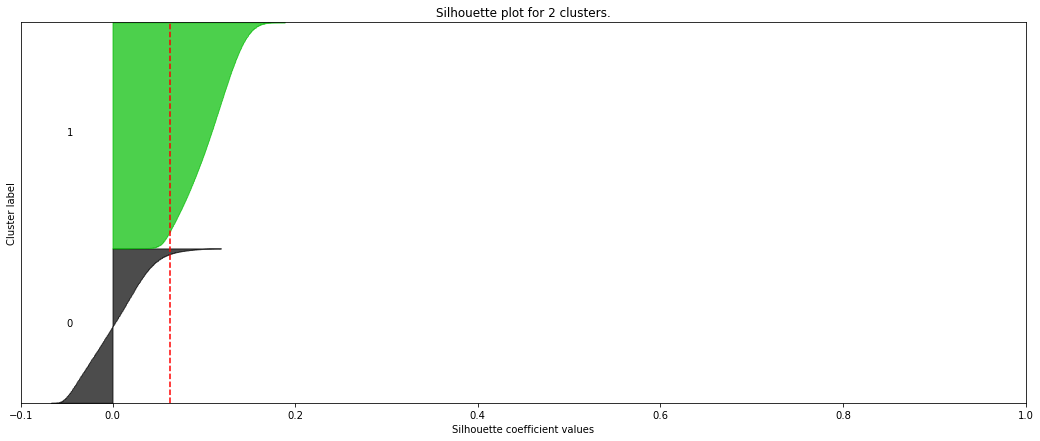

For n_clusters = 3 The average silhouette_score is : 0.06784069243894532


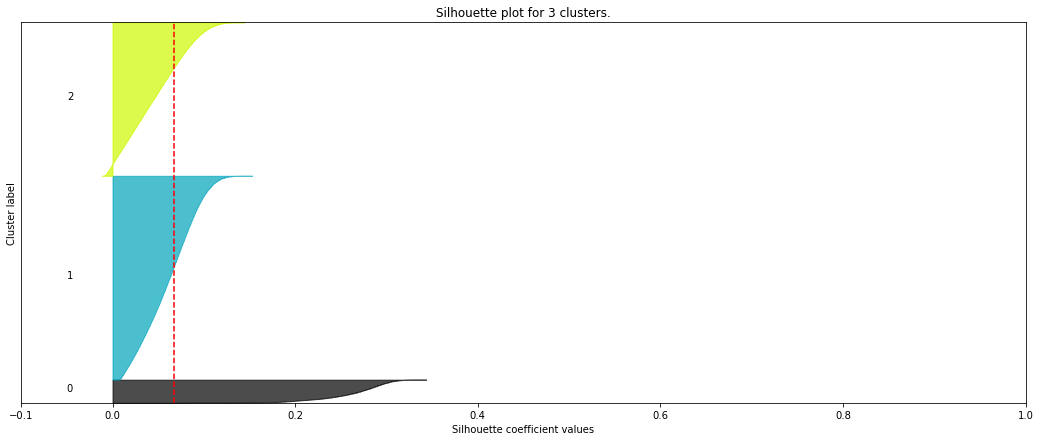

For n_clusters = 4 The average silhouette_score is : 0.05747290440727779


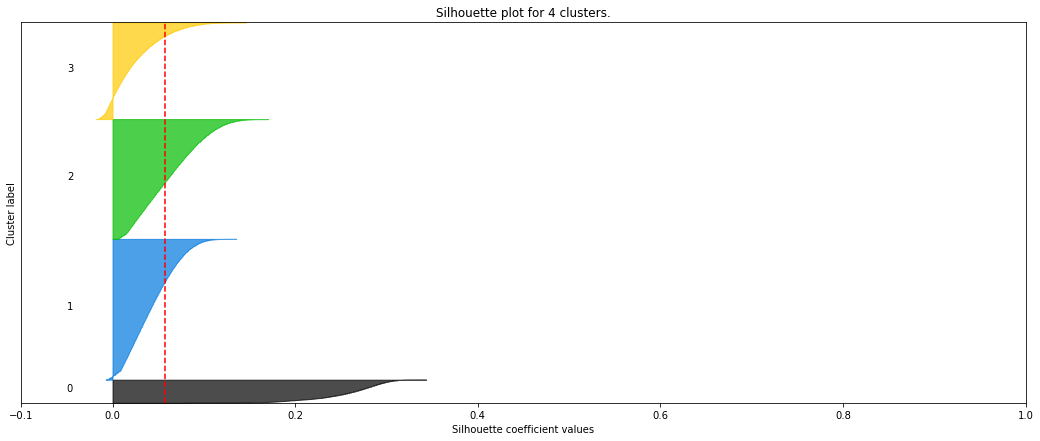

For n_clusters = 5 The average silhouette_score is : 0.04360491797768769


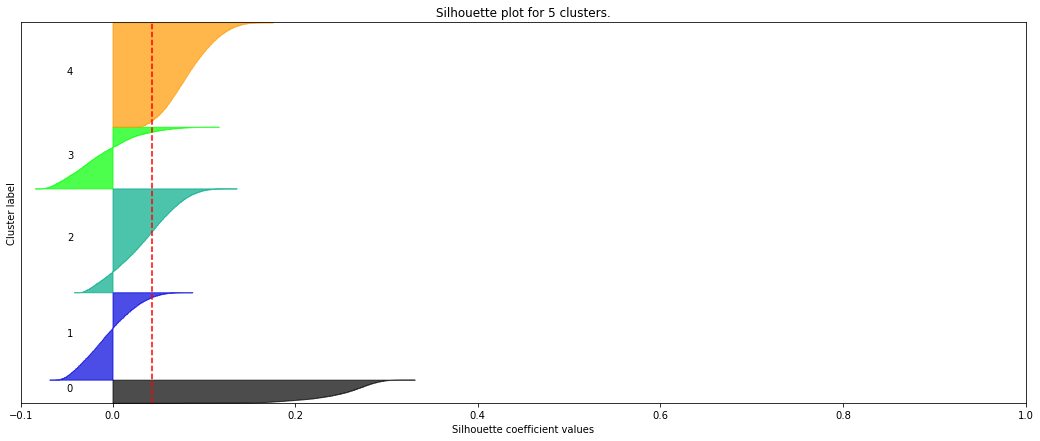

For n_clusters = 6 The average silhouette_score is : 0.04266763831060901


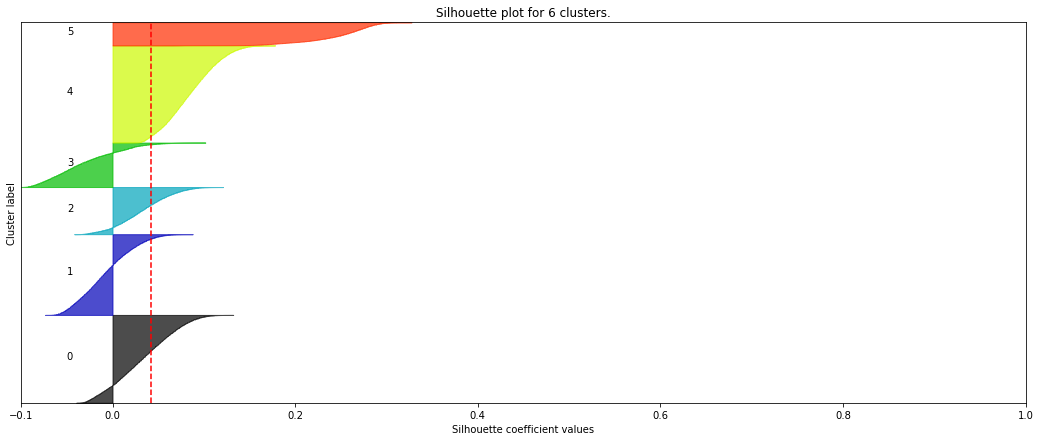

For n_clusters = 7 The average silhouette_score is : 0.03589986201850394


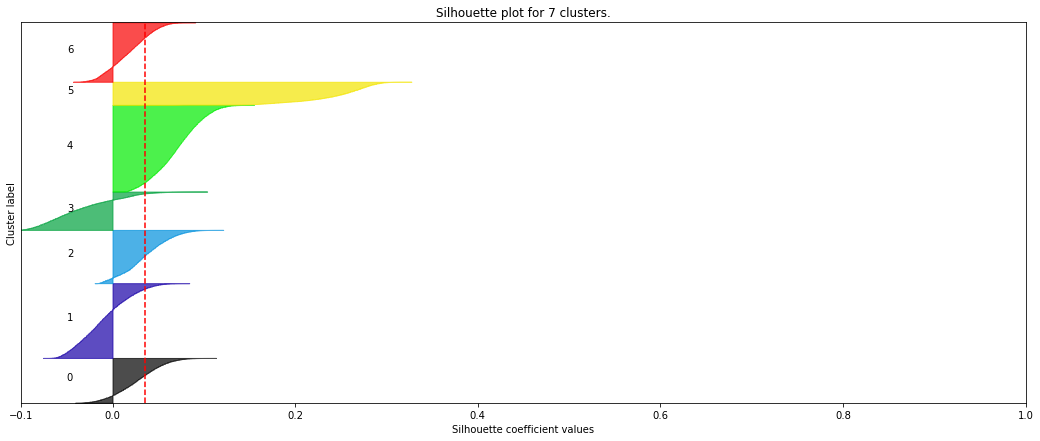

For n_clusters = 8 The average silhouette_score is : 0.03128116492371444


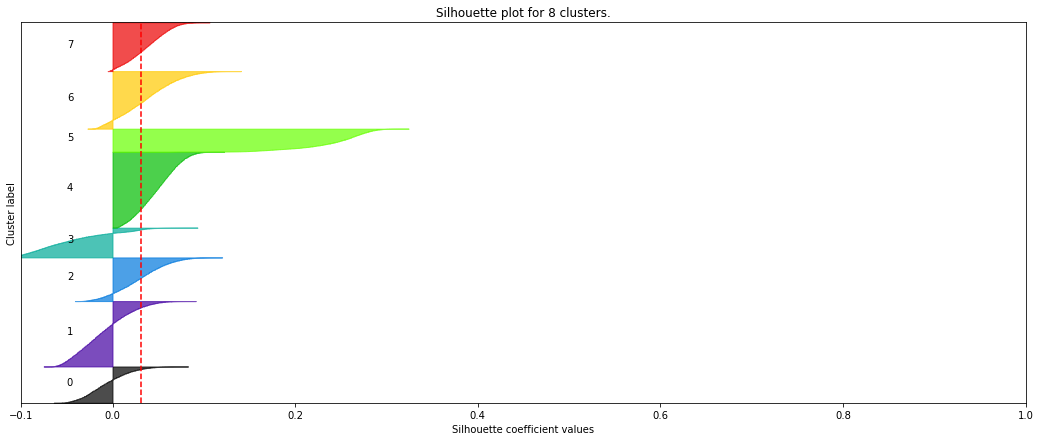

For n_clusters = 9 The average silhouette_score is : 0.03768536594620596
For n_clusters = 10 The average silhouette_score is : 0.03661114157070991
For n_clusters = 11 The average silhouette_score is : 0.035866949104202094
For n_clusters = 12 The average silhouette_score is : 0.03542722054886498
For n_clusters = 13 The average silhouette_score is : 0.03702706046329789
For n_clusters = 14 The average silhouette_score is : 0.03618753514543956
For n_clusters = 15 The average silhouette_score is : 0.036086018662652555
For n_clusters = 16 The average silhouette_score is : 0.036505857177608604
For n_clusters = 17 The average silhouette_score is : 0.035291892112649985
For n_clusters = 18 The average silhouette_score is : 0.025447461976970898
For n_clusters = 19 The average silhouette_score is : 0.02560604362073118
For n_clusters = 20 The average silhouette_score is : 0.023093416141944555


In [13]:
max_clusters = 20
sum_of_squared_distances = []
silhouette_scores = []

for n_clusters in range(2, max_clusters+1):
    # Initialize the clusterer with n_clusters value and a random generator
    clusterer = KMeans(n_clusters=n_clusters, n_init="auto", random_state=101)
    
    # Fit on the population dataset
    clusterer.fit(pca_population)
    
    # Predict on the population dataset
    cluster_labels = clusterer.predict(pca_population)
    
    # Sum of squared distances for the elbow method
    sum_of_squared_distances.append(clusterer.inertia_)
    
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(pca_population, cluster_labels)
    silhouette_scores.append(silhouette_avg)
        
    print(
        "For n_clusters =", n_clusters,
        "The average silhouette_score is :", silhouette_avg,
    )

    # create the silhouette plots only until 10 clusters
    if n_clusters <= 8:
        # Create a subplot with 1 row and 2 columns
        fig, ax = plt.subplots()
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        ax.set_xlim([-0.1, 1])

        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax.set_ylim([0, len(pca_population) + (n_clusters + 1) * 10])


        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(pca_population, cluster_labels)
        y_lower = 10

        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                ith_cluster_silhouette_values,
                facecolor=color,
                edgecolor=color,
                alpha=0.7,
            )

            # Label the silhouette plots with their cluster numbers at the middle
            ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax.set_title(f"Silhouette plot for {n_clusters} clusters.")
        ax.set_xlabel("Silhouette coefficient values")
        ax.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax.set_yticks([])  # Clear the yaxis labels / ticks
        ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        plt.show()

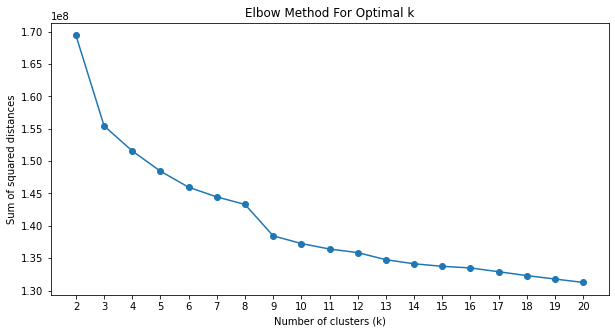

In [22]:
# Elbow Method Visualization
plt.figure(figsize=(10,5))
plt.plot(range(2, max_clusters+1, 1), sum_of_squared_distances, marker='o')
plt.xticks(np.arange(2, max_clusters+1, 1))
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show();

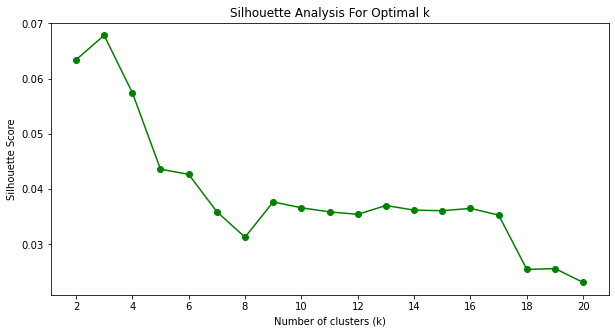

In [24]:
# Silhouette Scores Analysis Visualization:
plt.figure(figsize=(10,5))
plt.plot(range(2, max_clusters+1, 1), silhouette_scores, marker='o', color="green")
plt.xticks(np.arange(2, max_clusters+1, 2))
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis For Optimal k')
plt.show()

__Analysis__: 

### 1.2.2 Cluster Analysis
Using the number of `k=?`, we can now fit the final clustering model onto the population data and predict for both datasets. The next step is to look at the distribution of clusters and compare them. This will help us find clusters that may be overrepresented in our customer's data when comparing to the population, which in turn should be the target of a new mail campaign. In summary:
- __Target customers__ are the ones where the cluster's proportion is higher in the customer's dataset.
- __Non-target customers__ are the ones where the cluster's proportion is smaller in the customer's dataset.

The logic behind this is based on the principle of over-representation and understanding the current customer base using past data. 

In [ ]:
# Create the model with the chosen value of K and fit it on the population dataset
k = 5
clusterer = KMeans(n_clusters=k, n_init="auto", random_state=101)
clusterer.fit(pca_population)

In [ ]:
# Get the clusters for the population and the customers
population_clusters = clusterer.predict(pca_population)
customers_clusters = clusterer.predict(pca_customers)

In [ ]:
# Get the number of individuals per cluster and their proportions for the population dataset
n_clusters_population, counts_clusters_population = np.unique(population_clusters, return_counts=True)
n_clusters_population += 1

# Convert the stats into a dataframe
population_clusters_df = pd.DataFrame({
    'Count (Population)': counts_clusters_population,
    'Proportion (Population)': counts_clusters_population / len(population_clusters)
}, index=n_clusters_population)

# Get the number of individuals per cluster and their proportions for the customers dataset
n_clusters_customers, counts_clusters_customers = np.unique(customers_clusters, return_counts=True)
n_clusters_customers+=1

customers_clusters_df = pd.DataFrame({
    'Count (Customers)': counts_clusters_customers,
    'Proportion (Customers)': counts_clusters_customers / len(customers_clusters)
}, index=n_clusters_customers)


# Merge the two dataframes
clusters_proportions_df = pd.concat([population_clusters_df,customers_clusters_df], axis=1)
clusters_proportions_df = clusters_proportions_df.reset_index().rename(columns={"index":"Cluster"})
clusters_proportions_df["Proportion Difference"] = clusters_proportions_df["Proportion (Customers)"] - clusters_proportions_df["Proportion (Population)"]
clusters_proportions_df

In [ ]:
# Plot the clusters proportions
##############################################

# Setting the positions and width for the bars
width = 0.35
ind = np.arange(len(clusters_proportions_df['Cluster']))

fig, ax = plt.subplots()
fig.set_size_inches(10, 5)

# Creating bars for Proportions
p1 = ax.bar(ind - width/2, clusters_proportions_df['Proportion (Population)'], width, label='Population', color='#516FB9')
p2 = ax.bar(ind + width/2, clusters_proportions_df['Proportion (Customers)'], width, label='Customers', color='#FF9114')

# Setting labels, title, and legend
ax.set_xlabel('Cluster')
ax.set_ylabel('Proportions')
ax.set_title('Proportions by Cluster',  fontsize=16)
ax.set_xticks(ind)
ax.set_xticklabels(clusters_proportions_df['Cluster'])
ax.legend()

# Displaying the plot
plt.show()

In [ ]:
# Create a Dataframe with the characteristics of the centroids for each column in the customers dataset
centroids = sc.inverse_transform(pca.inverse_transform(clusterer.cluster_centers_))
df_centroids = pd.DataFrame(centroids, columns = customers_df.keys())
df_centroids = df_centroids.set_index(np.arange(1,len(clusters_proportions_df["Cluster"])+1))
df_centroids

In [ ]:
# Select the clusters of interest and the top 20 identified columns + additional demographic columns
top20_columns = ["FINANZ_SPARER", "HH_EINKOMMEN_SCORE", "LP_STATUS_FEIN", "MOBI_REGIO",
                 "ONLINE_AFFINITAET", "OST_WEST_KZ", "PLZ8_ANTG1", "PLZ8_ANTG3", "PLZ8_ANTG4",
                 "PLZ8_BAUMAX", "PLZ8_HHZ", "PRAEGENDE_JUGENDJAHRE", "SEMIO_ERL",
                 "SEMIO_FAM", "SEMIO_KAEM", "SEMIO_KRIT", "SEMIO_KULT", "SEMIO_PFLICHT",
                 "SEMIO_RAT", "SEMIO_TRADV"]

demographic_columns = ["ALTER_HH","CAMEO_DEUG_2015"]

target_columns = top20_columns + demographic_columns

# Create dataframes per target group with the centroid analysis
target_group_1 = df_centroids.loc[2, target_columns]
target_group_2 = df_centroids.loc[5, target_columns]
non_target_group_1 = df_centroids.loc[1, target_columns]
non_target_group_2 = df_centroids.loc[3, target_columns]

# Merge all dataframes together
centroids_by_cluster = pd.concat([target_group_1, target_group_2, non_target_group_1, non_target_group_2], axis=1)
centroids_by_cluster = centroids_by_cluster.rename(columns={2:"Target (C2)", 5:"Target (C5)", 1:"Non-Target (C1)", 3:"Non-Target (C3)"})

In [ ]:
# Plot heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(centroids_by_cluster.round(0), cmap='viridis', annot=True, linewidths=.5)
plt.title('Heatmap of the Cluster Centroids', fontsize=16)
plt.show()

# 2. Customer Segmentation Report
This is a part where sometimes data science can be more art than science and it is advisable to have a domain expert for this. Based on…

# 3. Model Deployment

In [ ]:
from joblib import dump, load

dump(sc, 'models\\population_scaler.joblib')
dump(pca, 'models\\population_pca.joblib')
dump(clusterer, 'models\\population_clusterer.joblib')